In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import itertools
import os

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

In [4]:
import datetime


In [5]:
from data_processor.indicator import (
    add_all_indicators,
    add_tech_indicator,
    tech_indicator_only,
)


In [6]:
import data_processor.config


In [7]:
price_df = pd.read_parquet("./data/sz50_price.parquet")
fund_df = pd.read_parquet("./data/sz50_fundament.parquet")


In [8]:
# df = add_all_indicators(price_df, fund_df)
df = add_tech_indicator(price_df)


In [9]:
df.head()


,date,tic,open,high,low,close,volume,amount,peTTM,pbMRQ,psTTM,pcfNcfTTM,SMA_20,SMA_60,SMA_120,macdhist,CCI,RSI,NATR,ADOSC
0,2008-01-02,sh.600000,53.00,55.05,51.81,53.55,13158390,7.098422e+08,48.425660,8.508562,9.844942,5.591184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,sh.600028,23.45,23.69,22.80,23.21,59245416,1.372896e+09,30.089169,6.871090,1.724764,-773.986004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,sh.600030,89.00,89.10,85.91,86.59,23966002,2.077683e+09,30.131683,6.079384,12.963651,2.048684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-02,sh.600031,57.13,57.65,55.50,56.34,4757848,2.694472e+08,39.487539,12.622559,6.717018,52.654244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-02,sh.600036,39.62,39.99,38.60,38.80,34141268,1.334724e+09,44.902636,9.064222,15.718772,7.446294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
available_tics = (
    df.set_index("date").loc[data_processor.config.FIRST_DAY_OF_2009].tic.tolist()
)


In [11]:
tmp_list = []
for tic in available_tics:
    tmp_df = df[df['tic'] == tic]
    tmp_list.append(tmp_df)
    
df = pd.concat(tmp_list, ignore_index=True)
    

In [12]:
train = data_split(df, "2009-01-01", "2020-01-01")
trade = data_split(df, "2020-01-01", "2022-01-01")


In [13]:
#indicators = data_processor.config.INDICATORS
indicators = ["SMA_20", "SMA_60", "SMA_120", "macdhist", "CCI", "RSI", "NATR", "ADOSC"]


In [14]:
n_indicators = len(indicators)
n_indicators


8

In [15]:
stock_dimension = len(df.tic.unique())
stock_dimension


34

In [16]:
state_space = 1 + (2 + n_indicators) * stock_dimension
state_space


341

In [17]:
env_kwargs = {
    "hmax": 1000,
    "initial_amount": 10000000,
    # "initial_list": [10000000] + [0 for i in range(stock_dimension)],
    # buy and sell cost for each stock
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)


In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))


<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### SAC

In [24]:
agent = DRLAgent(env=env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model(
    "sac", model_kwargs=SAC_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)


{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [25]:
trained_sac = agent.train_model(
    model=model_sac, tb_log_name="sac", total_timesteps=50000
)


Logging to tensorboard_log/sac_4
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 55       |
|    time_elapsed    | 193      |
|    total_timesteps | 10700    |
| train/             |          |
|    actor_loss      | 1.24e+06 |
|    critic_loss     | 2.03e+09 |
|    ent_coef        | 0.273    |
|    ent_coef_loss   | 513      |
|    learning_rate   | 0.0001   |
|    n_updates       | 10599    |
|    reward          | -8.87027 |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 54        |
|    time_elapsed    | 391       |
|    total_timesteps | 21400     |
| train/             |           |
|    actor_loss      | 9.59e+05  |
|    critic_loss     | 1.46e+09  |
|    ent_coef        | 0.795     |
|    ent_coef_loss   | 90.4      |
|    learning_rate   | 0.0001    |
|    n_updates       | 21299     |
| 

### DDPG

In [19]:
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 100000, "learning_rate": 0.0001}

agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model(
    "ddpg", model_kwargs=DDPG_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)


{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001}
Using cuda device


In [20]:
trained_ddpg = agent.train_model(
    model=model_ddpg, tb_log_name="ddpg", total_timesteps=100000
)


Logging to tensorboard_log/ddpg_4
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 90       |
|    time_elapsed    | 117      |
|    total_timesteps | 10700    |
| train/             |          |
|    actor_loss      | 3.05e+05 |
|    critic_loss     | 6.53e+09 |
|    learning_rate   | 0.0001   |
|    n_updates       | 8025     |
|    reward          | 64.42347 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 85       |
|    time_elapsed    | 251      |
|    total_timesteps | 21400    |
| train/             |          |
|    actor_loss      | 1.43e+05 |
|    critic_loss     | 6.12e+08 |
|    learning_rate   | 0.0001   |
|    n_updates       | 18725    |
|    reward          | 64.42347 |
---------------------------------
day: 2674, episode: 10
begin_total_asset: 10000000.00
end_total_asset: 56808624.51

In [21]:
model = trained_ddpg

### PPO

In [17]:
agent = DRLAgent(env=env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model(
    "ppo", model_kwargs=PPO_PARAMS, tensorboard_log=config.TENSORBOARD_LOG_DIR
)


{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [18]:
trained_ppo = agent.train_model(
    model=model_ppo, tb_log_name="ppo", total_timesteps=100000
)

model = trained_ppo


Logging to tensorboard_log/ppo_1
--------------------------------
| time/              |         |
|    fps             | 124     |
|    iterations      | 1       |
|    time_elapsed    | 16      |
|    total_timesteps | 2048    |
| train/             |         |
|    reward          | 8.81719 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 2           |
|    time_elapsed         | 32          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011270787 |
|    clip_fraction        | 0.0963      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.2       |
|    explained_variance   | 0.00108     |
|    learning_rate        | 0.0001      |
|    loss                 | 2.56e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0413     

## Backtest

In [22]:
e_trade_gym = StockTradingEnv(df=trade, **env_kwargs)


In [23]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=model, environment=e_trade_gym
)


hit end!


In [24]:
df_account_value.tail()


,date,account_value
481,2021-12-27,1.459602e+07
482,2021-12-28,1.456164e+07
483,2021-12-29,1.400757e+07
484,2021-12-30,1.421176e+07
485,2021-12-31,1.405363e+07


In [25]:
df_account_value.to_csv("./sz50_without_fund.csv")


In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)


==============Get Backtest Results===========
Annual return          0.192974
Cumulative returns     0.405363
Annual volatility      0.280029
Sharpe ratio           0.771471
Calmar ratio           0.533828
Stability              0.325749
Max drawdown          -0.361491
Omega ratio            1.138317
Sortino ratio          1.127978
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.132678
Daily value at risk   -0.034423
dtype: float64


In [27]:
from data_processor.ChinaStockDownloader import single_stock_query

baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")


login success!
logout success!


In [28]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")
baseline_df = baseline_df.apply(pd.to_numeric, errors="ignore")
stats = backtest_stats(baseline_df, value_col_name="close")


==============Get Baseline Stats===========
login success!
logout success!
Annual return          0.030354
Cumulative returns     0.059365
Annual volatility      0.207159
Sharpe ratio           0.248251
Calmar ratio           0.127942
Stability              0.258280
Max drawdown          -0.237251
Omega ratio            1.043889
Sortino ratio          0.346802
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977931
Daily value at risk   -0.025896
dtype: float64


In [29]:
test_ret = get_daily_return(df_account_value)
base_ret = get_daily_return(baseline_df, "close")


In [30]:
print("==============Compare to SZ50===========")
%matplotlib inline

import pyfolio

==============Compare to SZ50===========


In [34]:
with_fund = pd.read_csv("./sz50_with_fund.csv")
without_fund = pd.read_csv("./sz50_without_fund.csv")
with_fund_ret = get_daily_return(with_fund)
without_fund_ret = get_daily_return(without_fund)
with_fund_ret.index = pd.DatetimeIndex(with_fund_ret.index.date)
without_fund_ret.index = pd.DatetimeIndex(without_fund_ret.index.date)

In [31]:
test_ret.index = pd.DatetimeIndex(test_ret.index.date)
base_ret.index = pd.DatetimeIndex(base_ret.index.date)


In [35]:
import quantstats as qs

qs.reports.html(with_fund_ret, without_fund_ret)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Start date,2020-01-02
End date,2021-12-31
Total months,23
,Backtest
Annual return,19.297%
Cumulative returns,40.536%
Annual volatility,28.003%
Sharpe ratio,0.77
Calmar ratio,0.53
Stability,0.33
Max drawdown,-36.149%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.15,2021-02-10,2021-08-20,NaT,NaN
1,13.78,2020-07-13,2020-10-27,2020-12-31,124
2,13.77,2020-03-05,2020-03-19,2020-04-28,39
3,9.90,2020-01-13,2020-02-03,2020-02-20,29
4,4.46,2020-02-20,2020-02-28,2020-03-04,10


Stress Events,mean,min,max
New Normal,0.09%,-6.97%,6.40%


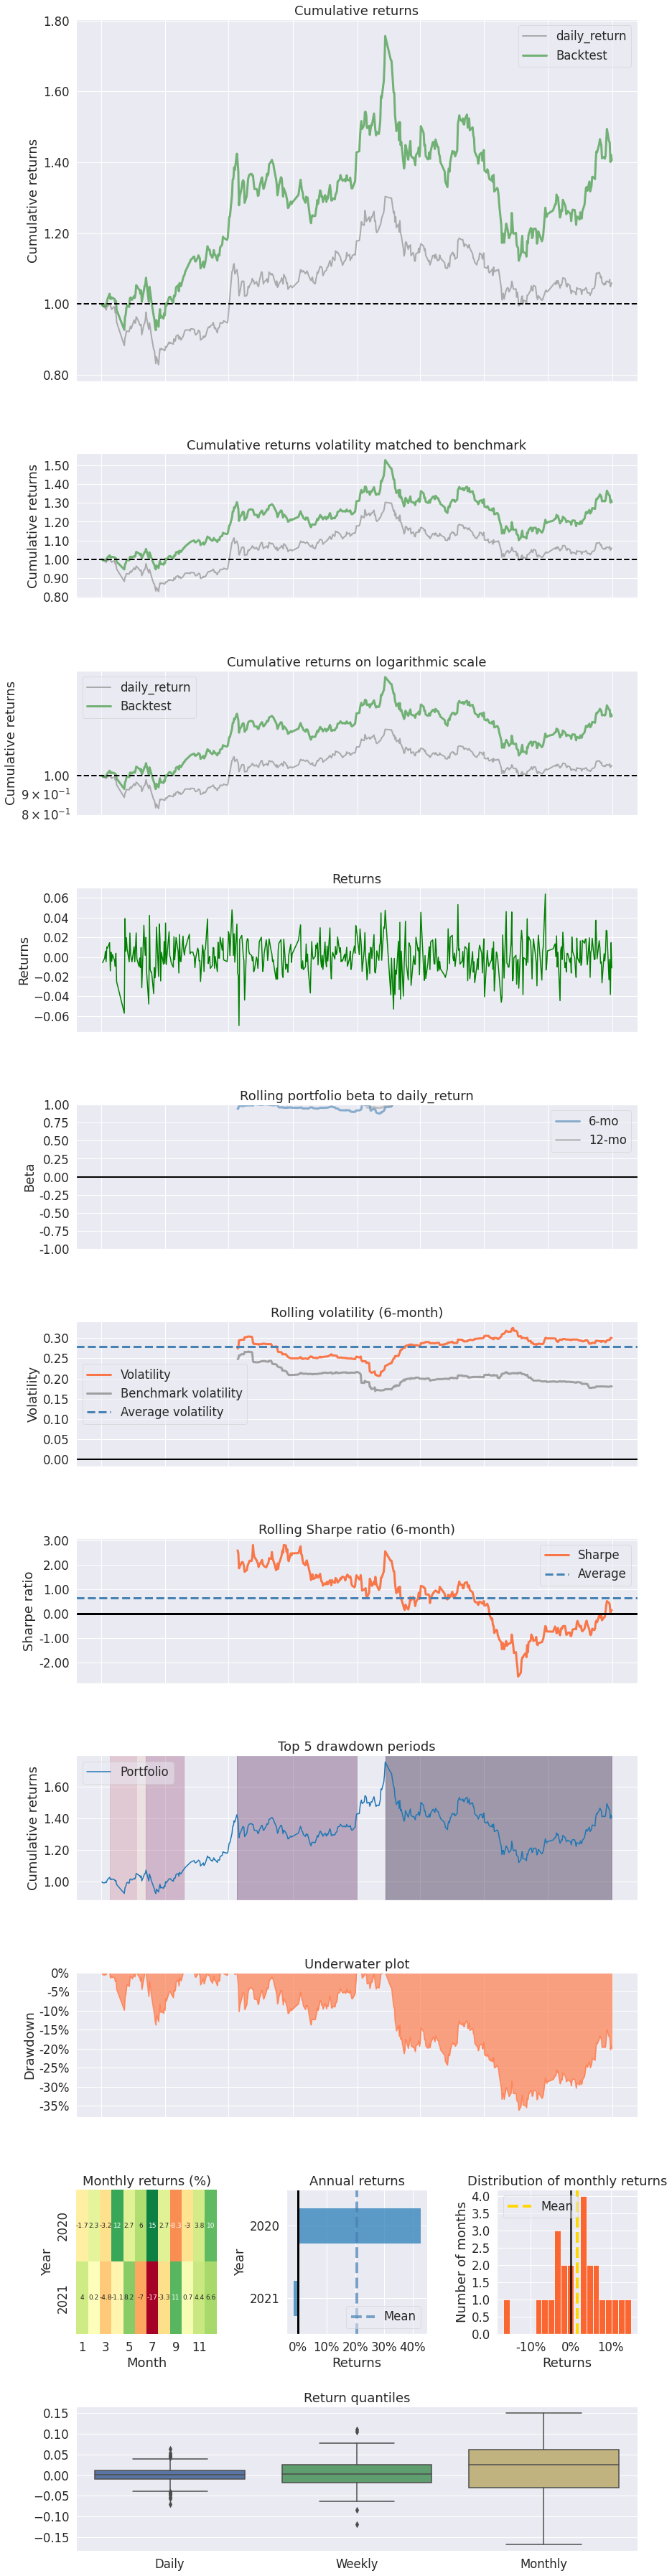

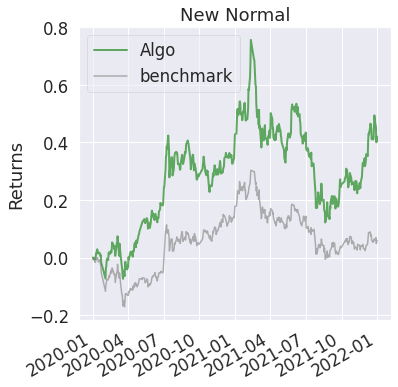

In [32]:
pyfolio.create_full_tear_sheet(returns=test_ret, benchmark_rets=base_ret)
